In [56]:
import numpy as np
import torch
from matplotlib import pyplot as plt
import gpytorch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

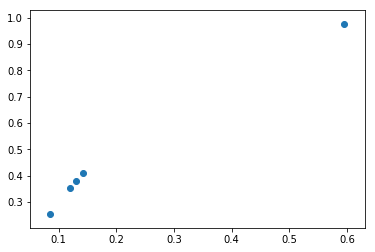

In [57]:
#generates data

num_datapoints = 5

def f(x):
    return np.sin(3*x)

xs = np.array([np.random.uniform(0,1) for i in range(num_datapoints)])
ys = f(xs)
plt.scatter(xs, ys)

In [73]:
class y_encoder(nn.Module):
    def __init__(self, y_size, hidden_layer_size, encoded_size):
        super(y_encoder, self).__init__()
        self.fc1 = nn.Linear(y_size, hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.fc3_mu = nn.Linear(hidden_layer_size, encoded_size)
        self.fc3_logvar = nn.Linear(hidden_layer_size, encoded_size**2)
        self.relu = nn.LeakyReLU()
        
    def forward(self, y):
        l1 = self.relu(self.fc1(y))
        l2 = self.relu(self.fc2(l1))
        mu = self.fc3_mu(l2)
        sigma = self.fc3_logvar(l2).mul(1/2).exp()
        return mu, sigma

class x_encoder(nn.Module):
    def __init__(self, x_size, hidden_layer_size, encoded_size):
        super(x_encoder, self).__init__()
        self.fc1 = nn.Linear(x_size, hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.fc3_mu = nn.Linear(hidden_layer_size, encoded_size)
        self.fc3_logvar = nn.Linear(hidden_layer_size, encoded_size**2)
        self.relu = nn.LeakyReLU()
        
    def forward(self, x):
        l1 = self.relu(self.fc1(x))
        l2 = self.relu(self.fc2(l1))
        mu = self.fc3_mu(l2)
        sigma = self.fc3_logvar(l2).mul(1/2).exp()
        return mu, sigma
    
def z_dist(x_mu, x_sigma, y_mu, y_sigma, x_size, y_size, encoded_size):
    x_mu = x_mu.reshape(x_size, encoded_size)
    y_mu = y_mu.reshape(y_size, encoded_size)
    mu = torch.cat([x_mu, y_mu])
    sigma = torch.diag(x_sigma, y_sigma)
    normal = torch.distributions.Normal(mu, sigma)
    return normal
    
class decoder(nn.Module):
    def __init__(self, encoded_size, y_size, hidden_layer_size):
        super(decoder, self).__init__()
        self.fc1 = nn.Linear(2*encoded_size, hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.fc3 = nn.Linear(hidden_layer_size, y_size)
        self.relu = nn.LeakyReLU()
        
    def forward(self, z):
        l1 = self.relu(self.fc1(z))
        l2 = self.relu(self.fc2(l1))
        mu = self.fc3(l2)
        return mu
    
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
def get_y(mu):
    normal = torch.distributions(mu, torch.ones(mu.size))
    return normal

class RegressionVAE(nn.Module):
    def __init__(self, x_size, y_size, hidden_layer_size, encoded_size, likelihood, xs, ys):
        super(RegressionVAE, self).__init__()
        self.x_enc = x_encoder(y_size, hidden_layer_size, encoded_size)
        self.y_enc = y_encoder(x_size, hidden_layer_size, encoded_size)
        self.dec = decoder(encoded_size, y_size, hidden_layer_size)
        self.regressor = ExactGPModel(xs, ys, likelihood)
        self.xs = xs
        self.ys = ys
        self.x_size = x_size
        self.y_size = y_size
        self.encoded_size = encoded_size
        
def train(vae, epochs):
    for epoch in range(epochs):
        error = 0
        for i in range(len(vae.xs)):
            optimizer.zero_grad()
            x = Variable(torch.tensor([vae.xs[i]]).type('torch.FloatTensor'))
            y = Variable(torch.tensor([vae.ys[i]]).type('torch.FloatTensor'))
            xmu, xsigma = vae.x_enc(x)
            ymu, ysigma = vae.y_enc(y)
            normal = z_dist(xmu, xsigma, ymu, ysigma, vae.x_size, vae.y_size, vae.encoded_size)
            zsample = normal.rsample()
            mu = vae.dec(z)
            y_new = get_y(mu)
            loss = vae.lossf(y_new, ys[i])
            error += loss
            loss.backward()
        if epoch % 100 == 0:
            print('EPOCH {}, LOSS {}'.format(epoch, error))

In [74]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = RegressionVAE(1, 1, 10, 3, likelihood, torch.from_numpy(xs), torch.from_numpy(ys))
optimizer = torch.optim.Adam(model.parameters())

In [75]:
train(model, 1)

TypeError: diag(): argument 'diagonal' (position 2) must be int, not Tensor